In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf
import imblearn
from sklearn.model_selection import train_test_split
import collections

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name
signal='elec'
bkg = 'pions'

In [3]:
bkg

'pions'

In [4]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]


df_sig= pd.read_csv(data_dir+'/{}.csv'.format(signal), usecols=columns, low_memory=True)
if bkg == 'QCD':
    columns =['event', 'genjet_n', 'genjet_energy', 'genjet_pt', 'genjet_eta',
       'genjet_phi', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta',
       'cl3d_phi', 
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'layer', 'deta', 'dphi',
       'deltar', 'matches',]
elif bkg == 'PU':
    columns = ['event', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta', 'cl3d_phi', 
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'layer',]

df_bkg= pd.read_csv(data_dir+'/{}.csv'.format(bkg), usecols=columns, low_memory=True)
df_bkg['sample']=bkg

print('done')

done
CPU times: user 6.97 s, sys: 800 ms, total: 7.77 s
Wall time: 7.8 s


In [5]:
"""df['genpart_exeta'][df['sample']=='PU']=0
df['genpart_pt'][df['sample']=='PU']=0
df['matches'][df['sample']=='PU']=0"""

"df['genpart_exeta'][df['sample']=='PU']=0\ndf['genpart_pt'][df['sample']=='PU']=0\ndf['matches'][df['sample']=='PU']=0"

# Config

In [6]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
#bkg='QCD' # 'pions' or 'PU'
standardize = "_unstandardized"
feature_set=16 # 1: baseline 4: minimal, 10-13 + new vars (12 -> PU 13-> pions)
opti=False
res_dir=workdir+'/res/res_pt{}_vs{}_featset{}{}'.format(genptcut, bkg, feature_set, standardize)
os.makedirs(res_dir, exist_ok=True)

In [7]:
from collections import Counter
count=Counter

In [8]:
%%time
df_sig['abseta']=np.abs(df_sig['cl3d_eta'])
df_bkg['abseta']=np.abs(df_bkg['cl3d_eta'])
sel = ((np.abs(df_sig['genpart_exeta'])>etamin) & (np.abs(df_sig['genpart_exeta'])<etamax )
       & (df_sig['genpart_pt']>genptcut)&  (df_sig['cl3d_pt']>cl3dptcut) 
       &(df_sig['abseta']>etamin) & (df_sig['abseta']<etamax ))
df_sig_cut=df_sig[sel]
df_sig_cut.dropna(inplace=True)
if bkg == 'QCD':
    sel = ((np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax )&(df_bkg['cl3d_pt']>cl3dptcut))
if bkg == 'pions':
    sel =  ((np.abs(df_bkg['genpart_exeta'])>etamin) & (np.abs(df_bkg['genpart_exeta'])<etamax )
       & (df_bkg['genpart_pt']>genptcut)&  (df_bkg['cl3d_pt']>cl3dptcut) 
       &(df_bkg['abseta']>etamin) & (df_bkg['abseta']<etamax ))
if bkg == 'PU':
    sel = ((np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax )&(df_bkg['cl3d_pt']>PU_cut))
df_bkg_cut=df_bkg[sel]
df_bkg_cut.dropna(inplace=True)
df_cut= df_sig_cut.append(df_bkg_cut)
print(count(df_cut['sample']))

Counter({'elec': 207350, 'pions': 6756})
CPU times: user 400 ms, sys: 147 ms, total: 547 ms
Wall time: 547 ms


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
%%time
#cut
algo_cut={}

def tolist(x):
    x.test=x.layer[1:-1].split(',')
    return x.test



#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))
#print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")



cl3d eta cut: 214106 207350
done
done layering36
CPU times: user 2min 43s, sys: 12.2 s, total: 2min 56s
Wall time: 2min 56s


In [10]:
Counter(df_cut['sample'])

Counter({'elec': 207350, 'pions': 6756})

In [11]:
# build new vars

#abseta
#df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 5
maxlast=10

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= Sum/sumT
    
for n in range(1,maxlast):
    Sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        Sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= Sum/sumT
    
    

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        Sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= Sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5

#print('emax_1')
Sum=0
Sum+=df_cut['layer_{}'.format(maxpos)]
df_cut['Emax_1']=Sum/sumT
 
#print('emax_2L')
Sum=0
for i in range(maxpos-1, maxpos+1):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2L']=Sum/sumT
    
#print('emax_2R')
Sum=0
for i in range(maxpos, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2R']=Sum/sumT
    
#print('emax_3')
Sum=0
for i in range(maxpos-1, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_3']=Sum/sumT
#print('emax_4G')
Sum=0
for i in range(maxpos-2, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4L']=Sum/sumT
#print('emax_4R')
Sum=0
for i in range(maxpos-1, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4R']=Sum/sumT
#print('emax_5')
Sum=0
for i in range(maxpos-2, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_5']=Sum/sumT
    
    
    

In [12]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

CPU times: user 2min 41s, sys: 5.67 s, total: 2min 46s
Wall time: 2min 43s


In [13]:
# try in last lay -> first

In [14]:
%%time
#do bitmaps with group
def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=0
    for i in range(n_layers-1,nLayerEcal-1, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)
print('done')

done
CPU times: user 2min 43s, sys: 5.22 s, total: 2min 48s
Wall time: 2min 45s


In [15]:
# quantization

def quantize(feat, nbits, method): #feat is the feature to quantize, nbist the number of bits, method: 'uniform' or 'percentile'
    nbins= 2**nbits
    fmin=feat.min()
    fmax=feat.max()
    if method == 'uniform':
        bins=np.linspace(fmin, fmax, nbins+1)
    elif method == 'percentile':
        bins=[np.percentile(feat, n) for n in np.linspace(0,100,nbins+1)]
    else :
        print('Error: Invalid method')
        return
    
    
    
    return np.digitize(feat, bins)

In [16]:
print(df_cut.columns.tolist())

['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'matches', 'sample', 'abseta', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_

In [17]:
#plot features distrib
plot= False
if plot:
    var_list= ['cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
           'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_spptot',
           'cl3d_szz', 'cl3d_srrtot',
           'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
           'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 
           'abseta', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2',
            'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
            'last_5', 'last_6', 'last_7', 'last_8', 'last_9', 'firstHcal_1', 'firstHcal_2',
            'firstHcal_3', 'firstHcal_4', 'firstHcal_5', 'Emax_1', 'Emax_2G', 'Emax_2R', 'Emax_3',
            'Emax_4L', 'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']

    nbins=100
    binmin=[1, 1, 1, 1, 0, 0, 0.0, 0.0, 0., -1.0, 328.15726, 0., 1.5, 4.004325, 0.67, 0.9, 1.6, 0, 0, 0.0, 0.0,
     0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0,0,0,0,0,0,0,0,0,0,0,0]
    binmax=[50.0, 36.0, 34.0, 50.0, 0.09, 0.075, 90, 0.01, 1, 5, 500, 36, 36, 36, 80, 200, 2.9, 0.007,
         0.005, 800, 0.0001, 1.0, 0.01, 0.03, 0.15, 0.5, 0.5,0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 
            0.3, 0.3,0.4, 0.6, 0.6,0.25,0.62,0.9,18000,9000,65536,18000,9000,65536]
    
    os.makedirs(workdir + '/distrib', exist_ok=True)
    for i,feat in enumerate(var_list):
        if i in [0,1,2,3]:
            nbins=36
        else: nbins= 100
        #print(feat, binmin[i], binmax[i])
        bins=np.linspace(binmin[i],binmax[i],nbins)
        plt.figure(figsize=(12,7))
        plt.hist(df_cut[feat][df_cut['sample']=='elec'], bins=bins, label='elec', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='pion'],bins=bins, label='pions', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='PU'],bins=bins, label='PU', density=True, histtype='step')
        plt.title("{} distribution ".format(feat))
        #plt.yscale('log')
        #plt.xlim(0,36)
        plt.legend()

        plt.savefig(workdir+'/distrib/{}.png'.format(feat))

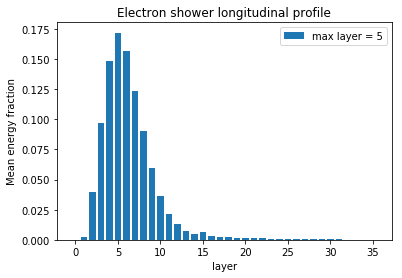

In [18]:
# plot longitudinal profile: mean fraction of elec pt / layer
frac={}
for n in range(n_layers):
    frac[n]=df_cut[df_cut['sample']=="elec"]['layer_{}'.format(n)]/df_cut[df_cut['sample']=="elec"]['cl3d_pt']
meanfrac=[frac[n].mean() for n in range(n_layers)]
plt.bar(range(n_layers),meanfrac, label= 'max layer = 5')
plt.xlabel('layer')
plt.ylabel('Mean energy fraction')
plt.title('Electron shower longitudinal profile')
plt.legend()

In [19]:


if bkg == 'pions':
    name = 'minimal w/ var & best pions '
    features =['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_5', 'ebm1', 'Emax_4R', 'hbm', 'firstHcal_1', 'reverse_ebm1']
    
        
elif bkg == 'PU':
    name = 'minimal w/ var & best PU '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                'firstHcal_5', 'Emax_4R', 'ebm1', 'Emax_2R', 'firstHcal_1', 'Emax_5']
    
elif bkg == 'QCD':
    name = 'minimal w/ var & best QCD '
    features=  ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT','ebm1', 'Emax_4R',
                'reverse_ebm1', 'first_2', 'Emax_2R', 'Emax_5', 
                ]
    

In [20]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':
    print('pions')

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='pions'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))
elif bkg == 'QCD':
    print('QCD')

    data=df_cut
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='QCD'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))

elif bkg == 'PU':
    print('PU')
    data=df_cut[df_cut['sample']!='pion']
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


pions
signal weight = 1.032582589823969, bkg weight =31.691237418590884


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

#blancing illustration: hoe vs meanz
test= X_train_untouched[['cl3d_hoe', 'cl3d_meanz']]
plt.figure()
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==0],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==0], label='pions', s=2 )
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==1],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

oversample=imblearn.over_sampling.ADASYN()
X_smote2d, y_smote2d=oversample.fit_resample(X=X_train_untouched , y=y_train_untouched['signal'])

plt.figure()
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==0],X_smote2d['cl3d_meanz'][y_smote2d==0], label='pions', s=2 )
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==1],X_smote2d['cl3d_meanz'][y_smote2d==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

#blancing illustration: hoe vs meanz
test= X_train_untouched[['cl3d_hoe', 'cl3d_meanz']]
plt.figure()
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==0],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==0], label='pions', s=2 )
plt.scatter(X_train_untouched['cl3d_hoe'][y_train_untouched['signal']==1],X_train_untouched['cl3d_meanz'][y_train_untouched['signal']==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

oversample=imblearn.over_sampling.SMOTE()
X_smote2d, y_smote2d=oversample.fit_resample(X=X_train_untouched , y=y_train_untouched['signal'])

plt.figure()
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==0],X_smote2d['cl3d_meanz'][y_smote2d==0], label='pions', s=2 )
plt.scatter(X_smote2d['cl3d_hoe'][y_smote2d==1],X_smote2d['cl3d_meanz'][y_smote2d==1], label='elec', s=2 )
plt.ylabel('meanz')
plt.xlabel('hoe')
plt.xlim(0,5)
plt.legend()

In [22]:
balancing='comb' #'SMOTE', 'weights', 'ada', 'under', 'comb'

In [23]:
Counter= collections.Counter

In [24]:
print(data.columns.to_list())

['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'matches', 'sample', 'abseta', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_

In [49]:
#normalize features
from sklearn import preprocessing
import pickle
scaler = preprocessing.StandardScaler()
x=data[features]

gridsearch_params = [
    (nbits, method)
    for nbits in [4,6,8,10,12]
    for method in ['uniform', 'percentile'] 
]
gs_len=len(gridsearch_params)
Results=pd.DataFrame(columns=['pred_test', 'true_test'])
for i,(nbits, method) in enumerate(gridsearch_params):
    print('iter {}/{}'.format(i+1, gs_len),nbits, method)
    X=data[features]
    for col in data[features].columns:
        X[col]=quantize(data[col], nbits, method)
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']],
                                                        test_size=0.2,random_state=42)

    ####balancing
    train_untouched=xgb.DMatrix(data=X_train,label=y_train['signal'],feature_names=features)
    y_train_untouched=y_train
    X_train_untouched=X_train
    scaler = preprocessing.StandardScaler()

    over_ratio = 0.2
    under_ratio = 0.5
    if bkg == 'QCD':
        over_ratio = 0.8
        under_ratio = 1
    for key in features:
            print(key, x[key].mean(), x[key].std())

    if balancing == 'SMOTE':
        oversample=imblearn.over_sampling.SMOTE()
        X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
        y_train=pd.DataFrame(y_train)
        y_train['weight']=1
    elif balancing == 'ada':
        oversample=imblearn.over_sampling.ADASYN()
        X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
        y_train=pd.DataFrame(y_train)
        y_train['weight']=1
    elif balancing == 'under':
        undersample= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=under_ratio)
        X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
        y_train=pd.DataFrame(y_train)
        y_train['weight']=1
    elif balancing == 'comb':
        over=imblearn.over_sampling.SMOTE(sampling_strategy=over_ratio, random_state=42)
        under= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=under_ratio, random_state=42)
        X_train, y_train=over.fit_resample(X_train,y_train['signal'])
        X_train, y_train=under.fit_resample(X_train, y_train)
        y_train=pd.DataFrame(y_train)
        y_train['weight']=1

    res_dir=workdir+'/res/res_pt{}_vs{}_featset{}/quantized{}_{}_{}'.format(genptcut, bkg, feature_set,nbits, method, balancing)
    os.makedirs(res_dir, exist_ok=True)
    train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features, weight=y_train['weight'])
    test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)

        
    ####DNN training
    #CV



    param = {
        'nthread' : 8,
        # Parameters that we are going to tune.
        'max_depth':2,
        'eta':0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Other parameters
        'objective':'binary:logistic',
        'eval_metric': 'auc', 
        'alpha':0.01,
        'lambda':10,
    }

    #use gpu if available
    gpu=tf.test.is_gpu_available(
        cuda_only=False, min_cuda_compute_capability=None
    )
    if gpu==True:
        param['tree_method']='gpu_hist'

    num_boost_round=200
    es_rounds=3

    metrics={'logloss','auc'} #last one used for es
    # set up cross validation:
    print('beginning cv')
    cv_results = xgb.cv(
        param,
        train,
        num_boost_round=num_boost_round,
        seed=40,
        nfold=5,
        metrics=metrics,
        #feval=SoverB,
        early_stopping_rounds=es_rounds,
        shuffle=True,
        verbose_eval=None
    )

    ## we define best score as the best test_auc penalized by the gap between train and test auc
    alpha=1 #(penalization)

    best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
    boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
    #print('best score:{} reached in {} rounds'.format(best_score, boost_rounds))
    #Now train and fit best parameters BDT



    #print('Training on {} events, signal : {}, bkg: {}'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
    #print('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
    eval_result = {}
    BDT = xgb.train(
        param,
        train,
        num_boost_round=int(boost_rounds),
        #feval = SoverB,
        evals=[(train, 'Train'),(test, "Test")],
        evals_result = eval_result,
        verbose_eval=None,
    )
    BDT.save_model(res_dir+'/model.model')
    print('model saved to {}'.format(res_dir+'/model.model'))
    #predictions_BDT_train=BDT.predict(train)
    #predictions_BDT_train_untouched=BDT.predict(train_untouched)
    Results.loc[i]=[BDT.predict(test), y_test['signal'].astype('int32')] 
    print('iteration over')
   
        

iter 1/10 4 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized4_uniform_comb/model.model
iteration over
iter 2/10 4 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized4_percentile_comb/model.model
iteration over
iter 3/10 6 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized6_uniform_comb/model.model
iteration over
iter 4/10 6 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized6_percentile_comb/model.model
iteration over
iter 5/10 8 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized8_uniform_comb/model.model
iteration over
iter 6/10 8 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized8_percentile_comb/model.model
iteration over
iter 7/10 10 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized10_uniform_comb/model.model
iteration over
iter 8/10 10 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized10_percentile_comb/model.model
iteration over
iter 9/10 12 uniform


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized12_uniform_comb/model.model
iteration over
iter 10/10 12 percentile


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


abseta 2.2343539658117937 0.3724639670146736
cl3d_firstlayer 1.0341746611491505 0.4667949216852616
varee 0.00040335006027732444 0.0003564009995721657
varpp 0.0004468971340287756 0.0003446612178497694
varzz 95.5796129023491 180.8681846668955
varrr 1.3897381751633613e-05 2.572846969686457e-06
cl3d_meanz 338.3252580097709 9.28976613554764
cl3d_showerlength 33.10780174306185 6.56266722078292
cl3d_coreshowerlength 14.380830056140416 2.122877923116427
EoT 0.9552206268190552 0.11933343033280107
Emax_5 0.6803344064383571 0.1273586844716207
ebm1 7924.458497192979 1401.600410365598
Emax_4R 0.5858259394697032 0.10535721083952636
hbm 1346638.7719914436 660617.1896605964
firstHcal_1 0.008428224903167927 0.02148480406721663
reverse_ebm1 5449.73953088657 5049.490522699277
beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:116: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


model saved to /grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vspions_featset16/quantized12_percentile_comb/model.model
iteration over


In [26]:
balancing

'comb'

In [46]:
#train without quantization
from sklearn.metrics import roc_curve, auc
X=data[features]


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']],
                                                    test_size=0.2,random_state=42)
over_ratio = 0.2
under_ratio = 0.5
if bkg == 'QCD':
    over_ratio = 0.8
    under_ratio = 1
####balancing
train_untouched=xgb.DMatrix(data=X_train,label=y_train['signal'],feature_names=features)
y_train_untouched=y_train
X_train_untouched=X_train
if balancing == 'SMOTE':
    oversample=imblearn.over_sampling.SMOTE()
    X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
    y_train=pd.DataFrame(y_train)
    y_train['weight']=1
elif balancing == 'ada':
    oversample=imblearn.over_sampling.ADASYN()
    X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
    y_train=pd.DataFrame(y_train)
    y_train['weight']=1
elif balancing == 'under':
    undersample= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=under_ratio)
    X_train, y_train=oversample.fit_resample(X=X_train , y=y_train['signal'])
    y_train=pd.DataFrame(y_train)
    y_train['weight']=1
elif balancing == 'comb':
    over=imblearn.over_sampling.SMOTE(sampling_strategy=over_ratio, random_state=42)
    under= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=under_ratio, random_state=42)
    X_train, y_train=over.fit_resample(X_train,y_train['signal'])
    X_train, y_train=under.fit_resample(X_train, y_train)
    y_train=pd.DataFrame(y_train)
    y_train['weight']=1

res_dir=workdir+'/res/res_pt{}_vs{}_featset{}/quantized{}_{}_{}'.format(genptcut, bkg, feature_set,nbits, method, balancing)
os.makedirs(res_dir, exist_ok=True)
train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features, weight=y_train['weight'])
test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)


####DNN training
#CV



param = {
    'nthread' : 8,
    # Parameters that we are going to tune.
    'max_depth':2,
    'eta':0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric': 'auc', 
    'alpha':0.01,
    'lambda':10,
}

#use gpu if available
gpu=tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
if gpu==True:
    param['tree_method']='gpu_hist'

num_boost_round=200
es_rounds=3

metrics={'logloss','auc'} #last one used for es
# set up cross validation:
print('beginning cv')
cv_results = xgb.cv(
    param,
    train,
    num_boost_round=num_boost_round,
    seed=40,
    nfold=5,
    metrics=metrics,
    #feval=SoverB,
    early_stopping_rounds=es_rounds,
    shuffle=True,
    verbose_eval=None
)

## we define best score as the best test_auc penalized by the gap between train and test auc
alpha=1#(penalization)

best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
#print('best score:{} reached in {} rounds'.format(best_score, boost_rounds))
#Now train and fit best parameters BDT



#print('Training on {} events, signal : {}, bkg: {}'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
#print('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
eval_result = {}
BDT = xgb.train(
    param,
    train,
    num_boost_round=int(boost_rounds),
    #feval = SoverB,
    evals=[(train, 'Train'),(test, "Test")],
    evals_result = eval_result,
    verbose_eval=None,
)
res=BDT.predict(test)
fpr, tpr, threshold = roc_curve(y_test['signal'],res, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
print(roc_auc_test)

beginning cv


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:96: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


0.9983144251016058


In [50]:
roc_auc_test


0.9983144251016058

In [48]:
booster.predict(test)

array([9.9923623e-01, 4.4241101e-03, 9.8953992e-01, ..., 9.9584275e-01,
       9.8654002e-01, 4.1299194e-04], dtype=float32)

In [28]:
#test import previous file: 
BDT_list={}
BDT_list[3]={'name' : 'minimal + bestnewpions',
       'path' : '/res/res_pt20_vs{}_featset5/{}'.format(bkg, balancing),
       'features' : ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_5', 'ebm1', 'Emax_4R', 'hbm', 'firstHcal_1', 'reverse_ebm1']
      }

for i in BDT_list:
    print(BDT_list[i]['name'])
    bdt=BDT_list[i]
    booster=xgb.Booster({'nthread' : 4})
    booster.load_model(workdir+bdt['path']+'/model.model')
    y_test[bdt['name']] = booster.predict(test)
    
fpr, tpr, threshold = roc_curve(y_test['signal'],y_test[bdt['name']], pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
print(roc_auc_test)

minimal + bestnewpions
0.9982573820201539


In [29]:
count(data['sample'])

Counter({'elec': 207350, 'pions': 6756})


AUC Score (Test): 99.831443%
AUC Score (Test): 99.783439%
AUC Score (Test): 99.798162%
AUC Score (Test): 99.820391%
AUC Score (Test): 99.812678%
AUC Score (Test): 99.843806%
AUC Score (Test): 99.831443%
AUC Score (Test): 99.772815%
AUC Score (Test): 99.786340%
AUC Score (Test): 99.784424%
AUC Score (Test): 99.786205%
AUC Score (Test): 99.792690%


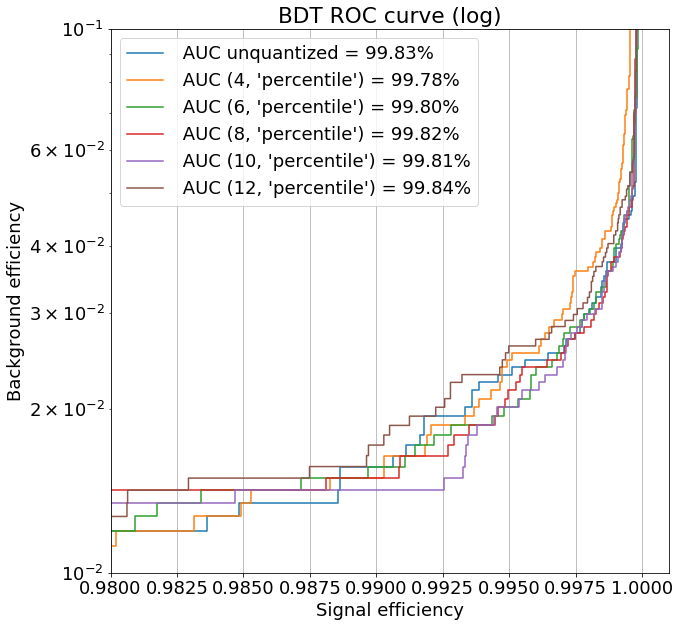

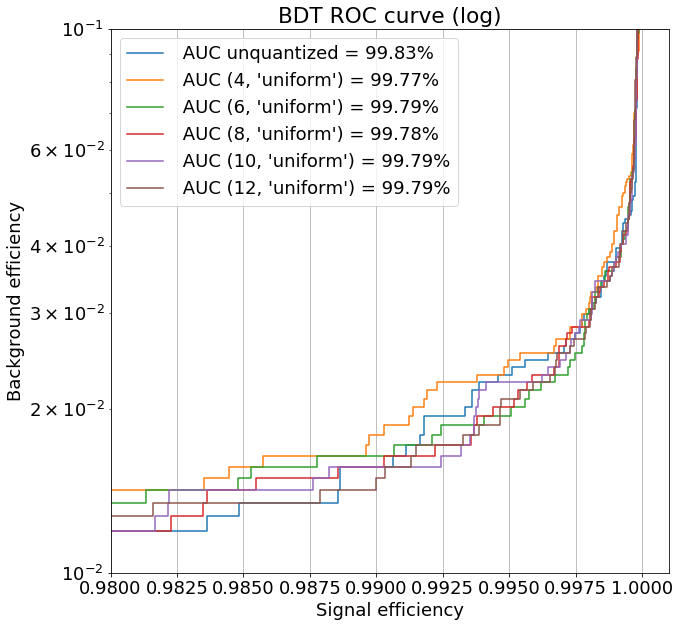

In [51]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'],res, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
print()
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,fpr, label =' AUC unquantized = {:2.2%}' .format(roc_auc_test))
for i in range(len(Results)):
    if 'uniform' not in gridsearch_params[i]:
        fpr, tpr, threshold = roc_curve(Results['true_test'].iloc[i],Results['pred_test'].iloc[i], pos_label=1)
        fpr.sort()
        tpr.sort()
        roc_auc_test = auc(fpr, tpr)
        print ("AUC Score (Test): {:4%}".format(roc_auc_test))
        plt.plot(tpr,fpr, label =' AUC {} = {:2.2%}' .format(gridsearch_params[i],roc_auc_test))
plt.yscale('log')
plt.xlim(0.98,1.001)
plt.ylim(1e-2,1e-1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend(loc='upper left')

plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'],res, pos_label=1)
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,fpr, label =' AUC unquantized = {:2.2%}' .format(roc_auc_test))
plt.savefig('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vsPU_featset6/quantile_comparison.png')
for i in range(len(Results)):
    if 'percentile' not in gridsearch_params[i]:
        fpr, tpr, threshold = roc_curve(Results['true_test'].iloc[i],Results['pred_test'].iloc[i], pos_label=1)
        fpr.sort()
        tpr.sort()
        roc_auc_test = auc(fpr, tpr)
        print ("AUC Score (Test): {:4%}".format(roc_auc_test))
        plt.plot(tpr,fpr, label =' AUC {} = {:2.2%}' .format(gridsearch_params[i],roc_auc_test))
plt.yscale('log')
plt.xlim(0.98,1.001)
plt.ylim(1e-2,1e-1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend(loc='upper left')
plt.savefig('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/res/res_pt20_vsPU_featset6/uniform_comparison.png')

In [32]:
X_train

,abseta,cl3d_firstlayer,varee,varpp,varzz,varrr,cl3d_meanz,cl3d_showerlength,cl3d_coreshowerlength,EoT,Emax_5,ebm1,Emax_4R,hbm,firstHcal_1,reverse_ebm1
0,1.697168,3.0,0.000070,0.000097,36.281576,0.000012,350.67430,30.0,12.0,0.950715,0.023997,255,0.023602,2031616,0.033148,16320
1,2.509463,1.0,0.000678,0.000640,1026.610814,0.000019,414.65106,47.0,17.0,0.075502,0.036516,512,0.026985,1572860,0.002241,16
2,2.866779,1.0,0.001429,0.001662,553.746741,0.000019,354.07327,46.0,25.0,0.714665,0.308937,8191,0.273638,2096649,0.116378,16382
3,1.911355,1.0,0.000261,0.000230,1910.791399,0.000026,380.45490,49.0,31.0,0.418929,0.204844,8191,0.172625,2097143,0.042346,16382
4,2.785811,1.0,0.002287,0.001822,624.437826,0.000030,357.94305,44.0,25.0,0.683899,0.246767,1020,0.218626,2096160,0.107536,4080
5,2.379557,1.0,0.000582,0.000531,837.709347,0.000021,375.69904,46.0,22.0,0.348987,0.013083,127,0.007263,2097146,0.161421,16256
6,2.780875,1.0,0.001335,0.001504,991.257998,0.000020,354.47253,50.0,21.0,0.740062,0.432067,8191,0.399665,2096120,0.054608,16382
7,2.495803,1.0,0.000494,0.000535,465.110946,0.000014,353.81433,45.0,28.0,0.861940,0.122425,1023,0.119938,2097072,0.033254,16368
8,2.126223,1.0,0.000704,0.000510,284.492484,0.000042,359.76273,41.0,18.0,0.508704,0.054117,127,0.031246,2087680,0.217654,16256
9,1.940878,3.0,0.000179,0.000238,659.936435,0.000015,362.54020,34.0,13.0,0.475918,0.225905,994,0.213084,2096640,0.066408,4592


In [33]:
res[0]

0.9418769

In [38]:
y_test[bdt['name']]

267859    0.999236
4694      0.004424
157190    0.989540
277973    0.997586
235852    0.997344
247855    0.983076
157155    0.993758
124608    0.999497
146979    0.999177
275507    0.998786
174509    0.999470
8517      0.998671
53940     0.999218
271205    0.998771
131243    0.999021
182255    0.960242
143042    0.992604
163527    0.999193
38738     0.999338
13658     0.999245
231350    0.999227
173156    0.998909
221018    0.999042
117133    0.993941
231768    0.980211
57217     0.997664
124855    0.996553
229102    0.999143
109786    0.997432
209786    0.999171
            ...   
39421     0.995182
58227     0.999214
260774    0.997739
79113     0.991996
255477    0.997552
111533    0.999424
147285    0.994833
5047      0.998771
26907     0.996822
264122    0.997315
93409     0.994019
234818    0.999224
52064     0.999128
52738     0.999278
115366    0.998732
226164    0.999236
169835    0.998663
190930    0.984419
199463    0.998998
139087    0.998115
53349     0.999123
117429    0.